In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pk
from MRPy import MRPy

# 1 - Coeficiente de Rayleigh:

In [3]:
with open('resources/data/sample_KM.pk','rb') as target:
    K1, M1, K2, M2, K3, M3 = pk.load(target)
with open('resources/data/sample_VM.pk','rb') as target:
    wk1, Phi1, wk2, Phi2, wk3, Phi3 = pk.load(target)
    
fk1 = wk1/2/np.pi
fk2 = wk2/2/np.pi
fk3 = wk3/2/np.pi

In [4]:
uk = 1e-3*np.array([[0.1303, 0.2325, 0.2833, 0.2325, 0.1303]]).T

In [5]:
Vmax = 1000*uk[2,0]/2
Tref = np.dot(uk.T, np.dot(M1,uk))[0,0]/2
fk = np.sqrt(Vmax/Tref)/2/np.pi

print('Coeficiente de Rayleigh: {0:4.2f}Hz'.format(fk)) 
print('Calculado por Autovetor: {0:4.2f}Hz'.format(fk1[0]))
print('Erro::                   {0:4.2f}% '.format(100*(fk - fk1[0])/fk1[0]))


Coeficiente de Rayleigh: 4.02Hz
Calculado por Autovetor: 3.94Hz
Erro::                   2.02% 


# 2 - Matriz de Amortecimento:

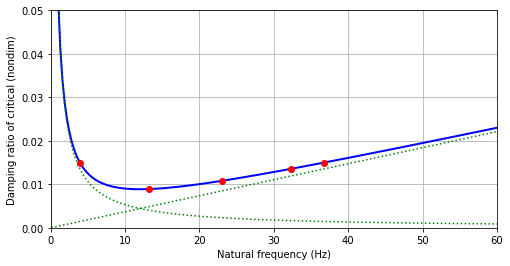

In [6]:
# Calculate the combination coefficients

wki = wk1[0];  zti = 0.015
wkj = wk1[4];  ztj = 0.015

alpha = np.linalg.solve([[1/(2*wki), wki/2], 
                         [1/(2*wkj), wkj/2]], [zti, ztj])

# Define damping as functions of frequency

ztM  = lambda fk: alpha[0]/(4*np.pi*fk)    # only M proportional
ztK  = lambda fk: alpha[1]*np.pi*fk        # only K proportional
ztMK = lambda fk: ztM(fk) + ztK(fk)        # mixed M and K model

# Visualize damping ratios for all vibration modes

fk1 = wk1/(2*np.pi)
fk  = np.linspace(0.1, 60, 200)

plt.figure(1, figsize=(8,4))
plt.plot(fk,  ztMK(fk ), 'b' , lw=2.0)
plt.plot(fk,  ztM (fk ), 'g:', lw=1.5)
plt.plot(fk,  ztK (fk ), 'g:', lw=1.5)
plt.plot(fk1, ztMK(fk1), 'ro')
plt.xlabel('Natural frequency (Hz)')
plt.ylabel('Damping ratio of critical (nondim)')
plt.axis([0, 60, 0, 0.05])

plt.grid(True)

# 3 - SUPERPOSIÇÃO NODAL NO DOMÍNIO DO TEMPO:

## 3.1 - EXEMPLO 1:

[[<matplotlib.lines.Line2D at 0x1d7e2dff490>],

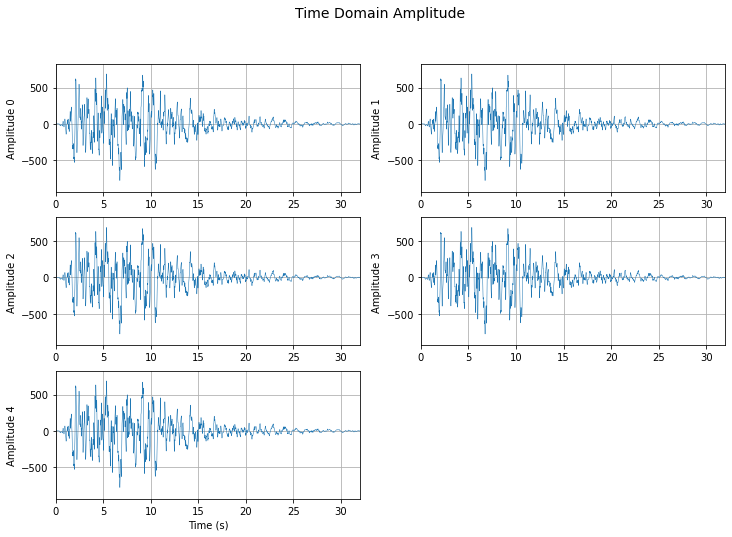

In [18]:
aG = MRPy.from_file('resources/data/earthquake', form='columns')

FG = np.dot(M1, np.tile(aG[0],(5,1)))
FG = MRPy(-FG, fs=aG.fs)

FG.plot_time()

In [19]:
wki = wk1[1]
zti = 0.01

wkj = wk1[4]
ztj = 0.01

alpha = np.linalg.solve([[ 1/(2*wki), wki/2],[1/(2*wkj), wkj/2]],[zti,ztj])

fk = wk1/(2*np.pi)
zk = ztMK(fk)

print(zk)

[0.02557434 0.01       0.00883985 0.00948302 0.01      ]


[[<matplotlib.lines.Line2D at 0x1d7e39da370>],

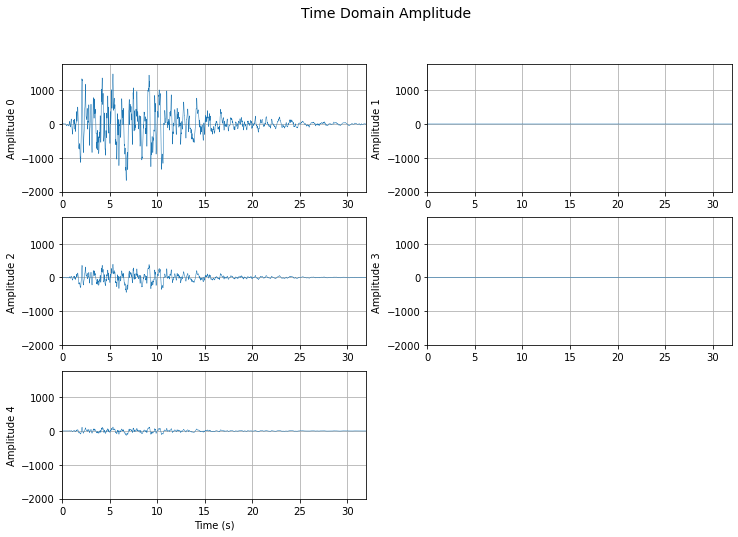

In [21]:
Mk = np.diag(np.dot(Phi1.T, np.dot(M1, Phi1)))
Kk = Mk*(wk1**2)
Fk = MRPy(np.dot(Phi1.T, FG), fs=FG.fs)

Fk.plot_time()

[[<matplotlib.lines.Line2D at 0x1d7e5bcda00>],

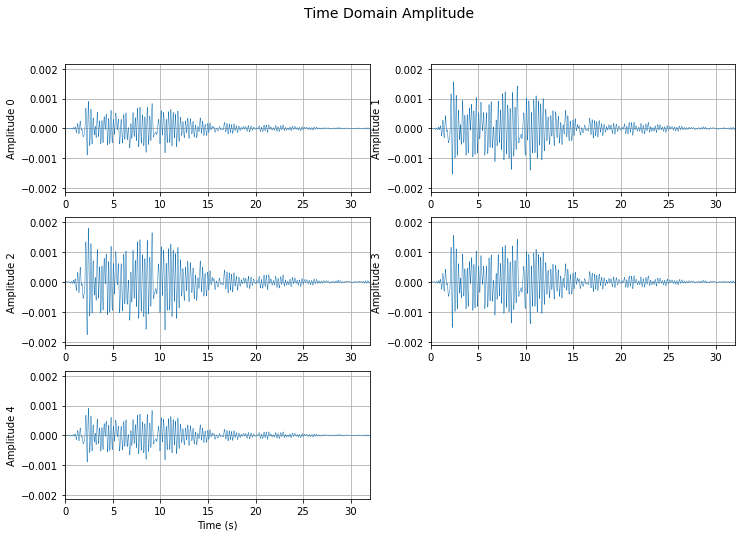

In [27]:
ak = MRPy(np.dot(np.diag(1/Mk), Fk), fs=Fk.fs)

uk = ak.sdof_Duhamel(fk,zk)

utot = MRPy(np.dot(Phi1, uk), fs=uk.fs)

utot.plot_time()

[ 3.93785233 13.28874904 23.0790977  32.38000947 36.76923945]


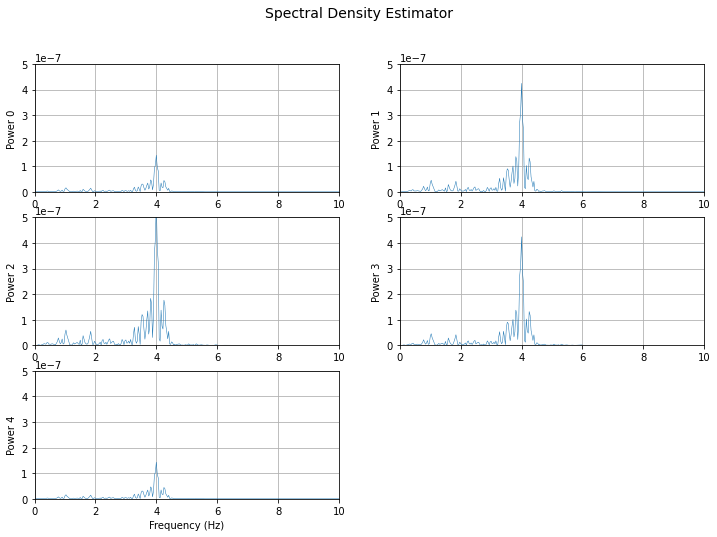

In [34]:
utot.plot_freq(axis_f = (0,10,0,5e-7))

print(fk)

# 5 - Truncando modos:

[[<matplotlib.lines.Line2D at 0x1d7e85721f0>],

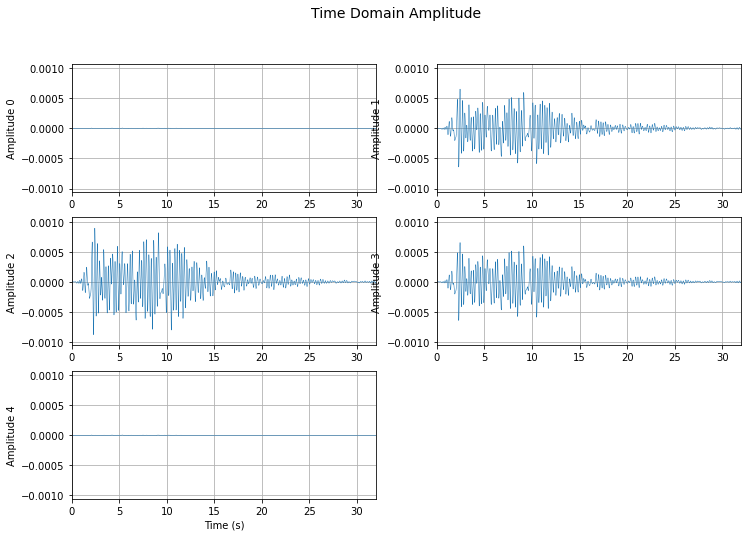

In [40]:
utot1 = np.zeros(uk.shape)
qk1 = Phi1[:,0]

for k in range(5):
    utot1 = uk[0]*qk1[k]
    utot1 += uk[1]*qk1[k]

err = MRPy(utot - utot1, fs=uk.fs)

err.plot_time()